In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

import os

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pandas.io.json import json_normalize

import urllib.request
import json
import codecs
from google2pandas import *

InteractiveShell.ast_node_interactivity = "all"
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
start = '2016-06-01'
end = '2017-05-03'

In [3]:
conn = GoogleAnalyticsQuery(token_file_name='analytics.dat', secrets='client_secrets_v3.json')

In [4]:
query_pageviews = {\
    'ids' : '48980166',
    'metrics' : ['pageviews', 'avgTimeOnPage'],
    'dimensions' : 'pagePath',
    'start_date' : start,
    'end_date' : end,
    'sort' : '-pageviews',
    'max_results' : 10000
    }

In [5]:
stats_weekly, metadata = conn.execute_query(**query_pageviews)

In [6]:
stats_weekly.sort_values('pageviews', ascending=False).head()

,pagePath,pageviews,avgTimeOnPage
0,/,3290560,108.06516047887033
1,/omniticker/,70642,108.45356863766605
2,/de/2015_06/leben/679721,47705,295.2537278106509
3,/classifieds,41839,85.9138770541692
4,/de/2016_29/international/724751,31023,318.1660416666667


In [7]:
stats_weekly['url'] = stats_weekly['pagePath'].str.split('/')

for i in range(0, len(stats_weekly['url'])):   
    try:
        stats_weekly.loc[i, 'article_id'] = stats_weekly['url'][i][4]
    except:
        stats_weekly.loc[i, 'article_id'] = ''
        
stats_weekly['article_id'] = pd.to_numeric(stats_weekly['article_id'], errors='coerce')
stats_weekly['pageviews'] = pd.to_numeric(stats_weekly['pageviews'], errors='coerce')
stats_weekly['avgTimeOnPage'] = pd.to_numeric(stats_weekly['avgTimeOnPage'], errors='coerce')


stats_weekly = stats_weekly.dropna()

In [8]:
stats_pageviews = stats_weekly.groupby(by=['article_id']).pageviews.sum()
stats_pageviews = stats_pageviews.to_frame(name = 'pageviews')
stats_pageviews = stats_pageviews.reset_index()

stats_pageviews.head()

,article_id,pageviews
0,1.0,757
1,10.0,91
2,3915.0,863
3,3917.0,3848
4,3918.0,4288


In [9]:
stats_readtime = stats_weekly.groupby(by=['article_id']).avgTimeOnPage.mean()
stats_readtime = stats_readtime.to_frame(name = 'readtime')
stats_readtime = stats_readtime.reset_index()

stats_readtime.head()

,article_id,readtime
0,1.0,59.419062
1,10.0,127.400000
2,3915.0,87.659363
3,3917.0,88.189684
4,3918.0,122.236328


In [163]:
def get_articles_by_topic(id):
    print(id)
    topics = pd.DataFrame(columns=['article_id', 'topic_id'])
    result = pd.DataFrame(columns=['article_id', 'topic_id'])
    i = 0;
    try:
        url = 'http://www.tageswoche.ch/content-api/topics/' + str(id) + '/de/articles'
        response = urllib.request.urlopen(url)
        reader = codecs.getreader("utf-8")
        obj = json.load(reader(response))
        itemsCount = obj['pagination']['itemsCount']
        itemsPages = np.ceil(itemsCount / 10) + 1
        page = 1;
        for page in range(1, int(itemsPages)):
            try:
                url_pages = url + '?page=' + str(page) + '&items_per_page=10'
                response = urllib.request.urlopen(url_pages)
                reader = codecs.getreader("utf-8")
                obj = json.load(reader(response))
                for i in range(0, len(obj['items'])):
                    result.loc[i, 'article_id'] = obj['items'][i]['number']
                    result.loc[i, 'title'] = obj['items'][i]['title']
                    result.loc[i, 'published'] = obj['items'][i]['published']
            except:
                result['article_id'] = ''
                result['published'] = ''
                result['title'] = ''
                pass

            topics = topics.append(result)
    except:
        try:
            print('no-pagination')
            url = 'http://www.tageswoche.ch/content-api/topics/' + str(id) + '/de/articles'
            response = urllib.request.urlopen(url)
            reader = codecs.getreader("utf-8")
            obj = json.load(reader(response))
            for i in range(0, len(obj['items'])):
                topics.loc[i, 'article_id'] = obj['items'][i]['number']
                topics.loc[i, 'title'] = obj['items'][i]['title']
                topics.loc[i, 'published'] = obj['items'][i]['published']
        except:
            print('error')
            pass
    
    topics['topic_id'] = id
    topics = topics.drop_duplicates()
    print('success')
    #topics = topics.reset_index()
    #topics = topics[['article_id', 'topic_id']]
    return topics


articles_by_topic = get_articles_by_topic(1041)

articles_by_topic.head()

1041
success


,article_id,published,title,topic_id
0,747920,2017-04-24T05:30:02+0200,Hot Dogs – Biss in die Freiheit,1041
1,746399,2017-04-01T04:50:02+0200,Die Frauenwelt jubelt: Endlich gibts einen Reg...,1041
2,746325,2017-03-30T15:49:42+0200,Mavic Pro – Fliegen ist schöner!,1041
3,743802,2017-03-17T04:50:06+0100,"Frauen, steht zu eurem Blut!",1041
4,743934,2017-03-06T04:50:01+0100,"Kaffi Lutz, der zu Unrecht verpönte Drink",1041


In [164]:
articles_by_topic['published'] = articles_by_topic['published'].str.extract('(\d\d\d\d-\d\d-\d\d)')

articles_by_topic = articles_by_topic[articles_by_topic.published != '0001-11-30']

articles_by_topic['published'] = pd.to_datetime(articles_by_topic['published'], format='%Y-%m-%d')

articles_by_topic.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


,article_id,published,title,topic_id
0,747920,2017-04-24,Hot Dogs – Biss in die Freiheit,1041
1,746399,2017-04-01,Die Frauenwelt jubelt: Endlich gibts einen Reg...,1041
2,746325,2017-03-30,Mavic Pro – Fliegen ist schöner!,1041
3,743802,2017-03-17,"Frauen, steht zu eurem Blut!",1041
4,743934,2017-03-06,"Kaffi Lutz, der zu Unrecht verpönte Drink",1041


In [165]:
articles_by_topic['week'] = articles_by_topic['published'].dt.week
articles_by_topic['month'] = articles_by_topic['published'].dt.month
articles_by_topic['year'] = articles_by_topic['published'].dt.year

articles_by_topic.head()


,article_id,published,title,topic_id,week,month,year
0,747920,2017-04-24,Hot Dogs – Biss in die Freiheit,1041,17,4,2017
1,746399,2017-04-01,Die Frauenwelt jubelt: Endlich gibts einen Reg...,1041,13,4,2017
2,746325,2017-03-30,Mavic Pro – Fliegen ist schöner!,1041,13,3,2017
3,743802,2017-03-17,"Frauen, steht zu eurem Blut!",1041,11,3,2017
4,743934,2017-03-06,"Kaffi Lutz, der zu Unrecht verpönte Drink",1041,10,3,2017


In [166]:
articles_by_topic['article_id'] = pd.to_numeric(articles_by_topic['article_id'], errors='coerce')

In [167]:
stats_merged = stats_pageviews.merge(articles_by_topic, left_on='article_id', right_on='article_id')

In [168]:
stats_timespan = stats_merged.set_index(['published'])
stats_timespan = stats_timespan.loc[start:end]
stats_timespan = stats_timespan.reset_index()

stats_timespan.head()

,published,article_id,pageviews,title,topic_id,week,month,year
0,2016-09-06,725713.0,4796,Die Edelpuffer,1041,36,9,2016
1,2016-09-12,729308.0,3373,Schmuck aus Muttermilch ist Pflicht für jedes ...,1041,37,9,2016
2,2016-09-19,729605.0,483,Hässlich + unpraktisch = Crocs mit Fell,1041,38,9,2016
3,2016-10-29,729647.0,553,Die erste Herbstmesse-App im Test,1041,43,10,2016
4,2016-09-26,730529.0,336,Wie geschaffen für Befürworter des neuen Nachr...,1041,39,9,2016


In [169]:
stats_timespan.to_csv('supersach.csv')

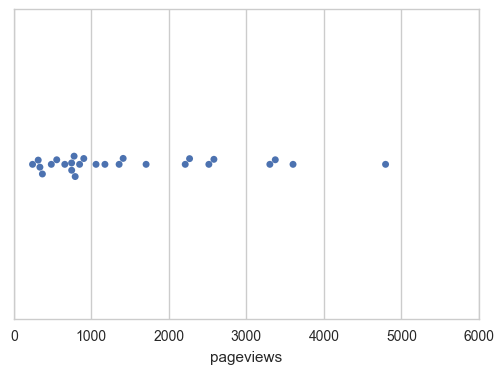

In [170]:

sns.set_style("whitegrid")

#topics = sns.load_dataset("topics_export")
#ax = sns.boxplot(x=topics_stats_details['Seitenaufrufe'])

ax = sns.swarmplot(x=stats_timespan['pageviews'], orient='h')

ax.yaxis.label.set_visible(False)

In [145]:
weekly_stats = stats_merged.groupby(['week', 'year']).pageviews.sum()
weekly_stats = weekly_stats.to_frame(name = 'weekly_pageviews')
weekly_stats = weekly_stats.reset_index()

weekly_stats.to_csv('kultwerk_weekly.csv')

In [132]:
monthly_stats = stats_merged.groupby(['month', 'year']).pageviews.sum()
monthly_stats = monthly_stats.to_frame(name = 'monthly_pageviews')
monthly_stats = monthly_stats.reset_index()

monthly_stats.to_csv('wochenendlich_monthly.csv')

# News vs. newswire Baseline

In [10]:
def parse_articles(id):
    meta = pd.DataFrame(columns=['type', 'article_id'])
    url = 'http://www.tageswoche.ch/content-api/articles/'
    article_name = url + str(id)
    #print(id)
    try:
        df = pd.read_json(article_name, lines=True)
        meta['type'] = df['type']
        meta['published'] = df['published']
        meta['title'] = df['title']
        meta['url'] = df['url']
        meta['comments'] = df['comments_count']
    except:
        pass
    meta['article_id'] = id
    return meta

filepath = 'weekly_report/tawo_stats_meta_baseline.csv'

if os.path.exists(filepath):
    df = pd.read_csv(filepath, usecols=[1, 2, 3, 4, 5, 6])
else:
    df = pd.concat([parse_articles(id) for id in stats_pageviews['article_id']])

df.head()

,article_id,comments,published,title,type,url
0,3915.0,0.0,2011-10-07,AGB,static_page,http://www.tageswoche.ch/de/pages/about/3915/a...
1,3917.0,0.0,2011-10-07,Impressum,static_page,http://www.tageswoche.ch/de/pages/about/3917/i...
2,3918.0,0.0,2011-10-07,Kontakt,static_page,http://www.tageswoche.ch/de/pages/about/3918/k...
3,3919.0,0.0,2011-10-07,Community-Leitfaden,static_page,http://www.tageswoche.ch/de/pages/about/3919/c...
4,3923.0,0.0,2011-10-07,Über uns,static_page,http://www.tageswoche.ch/de/pages/about/3923/u...


In [11]:
df['published'] = df['published'].str.extract('(\d\d\d\d-\d\d-\d\d)')

df = df[df.published != '0001-11-30']

df['published'] = pd.to_datetime(df['published'], format='%Y-%m-%d')

df.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


,article_id,comments,published,title,type,url
0,3915.0,0.0,2011-10-07,AGB,static_page,http://www.tageswoche.ch/de/pages/about/3915/a...
1,3917.0,0.0,2011-10-07,Impressum,static_page,http://www.tageswoche.ch/de/pages/about/3917/i...
2,3918.0,0.0,2011-10-07,Kontakt,static_page,http://www.tageswoche.ch/de/pages/about/3918/k...
3,3919.0,0.0,2011-10-07,Community-Leitfaden,static_page,http://www.tageswoche.ch/de/pages/about/3919/c...
4,3923.0,0.0,2011-10-07,Über uns,static_page,http://www.tageswoche.ch/de/pages/about/3923/u...


In [113]:
df.to_csv(filepath)

In [15]:
# merge google stats and article meta data

stats_metainfo = df.merge(stats_pageviews, left_on='article_id', right_on='article_id')

#df = df.drop_duplicates()

stats_metainfo.head()

,article_id,comments,published,title,type,url,pageviews
0,3915.0,0.0,2011-10-07,AGB,static_page,http://www.tageswoche.ch/de/pages/about/3915/a...,863
1,3917.0,0.0,2011-10-07,Impressum,static_page,http://www.tageswoche.ch/de/pages/about/3917/i...,3848
2,3918.0,0.0,2011-10-07,Kontakt,static_page,http://www.tageswoche.ch/de/pages/about/3918/k...,4288
3,3919.0,0.0,2011-10-07,Community-Leitfaden,static_page,http://www.tageswoche.ch/de/pages/about/3919/c...,594
4,3923.0,0.0,2011-10-07,Über uns,static_page,http://www.tageswoche.ch/de/pages/about/3923/u...,2511


In [16]:
stats_metainfo = stats_metainfo.merge(stats_readtime, left_on='article_id', right_on='article_id')
stats_metainfo.head()

,article_id,comments,published,title,type,url,pageviews,readtime
0,3915.0,0.0,2011-10-07,AGB,static_page,http://www.tageswoche.ch/de/pages/about/3915/a...,863,87.659363
1,3917.0,0.0,2011-10-07,Impressum,static_page,http://www.tageswoche.ch/de/pages/about/3917/i...,3848,88.189684
2,3918.0,0.0,2011-10-07,Kontakt,static_page,http://www.tageswoche.ch/de/pages/about/3918/k...,4288,122.236328
3,3919.0,0.0,2011-10-07,Community-Leitfaden,static_page,http://www.tageswoche.ch/de/pages/about/3919/c...,594,107.167442
4,3923.0,0.0,2011-10-07,Über uns,static_page,http://www.tageswoche.ch/de/pages/about/3923/u...,2511,45.893247


In [20]:
stats_metainfo['type'] = stats_metainfo['type'].astype('category')

stats_metainfo_news = stats_metainfo[(stats_metainfo.type == 'news')]

stats_metainfo_news.head()

,article_id,comments,published,title,type,url,pageviews,readtime
6,80382.0,0.0,2011-10-27,Die TagesWoche: Mehr als eine Zeitung,news,http://www.tageswoche.ch/de/2011_43/dialog/803...,269,175.650943
7,80405.0,1.0,2011-10-27,Plündern im Pilzparadies,news,http://www.tageswoche.ch/de/2011_43/basel/8040...,208,408.809524
8,80423.0,0.0,2011-10-27,Schweizerhalle: Die Lehren aus dem Unfall,news,http://www.tageswoche.ch/de/2011_43/basel/8042...,314,283.467742
10,97670.0,6.0,2011-10-29,"Der Mann, der die Hölle von Schweizerhalle fot...",news,http://www.tageswoche.ch/de/2011_43/basel/9767...,218,295.545455
11,103417.0,3.0,2011-11-01,Vor 25 Jahren hielt Basel den Atem an,news,http://www.tageswoche.ch/de/2011_43/basel/1034...,179,133.200000


In [21]:
data_subset_news = stats_metainfo_news.set_index(['published'])

data_subset_news_week = data_subset_news.loc[start:end]

In [22]:
data_subset_news_week = data_subset_news_week.reset_index()

In [23]:
data_subset_news_week['comments'].corr(data_subset_news_week['pageviews'], method='pearson')

0.4109468480768112

In [24]:
data_subset_news_week['comments'].corr(data_subset_news_week['readtime'], method='pearson')

0.16360008945106336

In [29]:
from scipy.stats import pearsonr

pearsonr(data_subset_news_week['comments'], data_subset_news_week['pageviews'])

(0.41094684807681126, 8.9106309167767425e-119)

In [32]:
import facebook

token = 'EAAaZBFx0Bj1wBAMl8ZADFZBQ0BGXdfGuwZA9Nfhl3ArEFel8nvIUWdMWA4FEmOzAs8zWKm72gUUD48sH8fh3fork3bL6gNDgJGm93pwiLLIEsdxp8Mmj4wZBHJKgKHifdqSOak8aAW53krXbmIPrlH6mSgbPPoY6RxZB98tvciX9fsF93Vi0scDfR2sMH5hcsZD'
graph = facebook.GraphAPI(access_token=token, version='2.8')

app_id = '1897856340430684' # Obtained from https://developers.facebook.com/
app_secret = 'afd88726fc4b0c589e30f5cd1293b92e' # Obtained from https://developers.facebook.com/

# Extend the expiration time of a valid OAuth access token.
extended_token = graph.extend_access_token(app_id, app_secret)
extended_token #verify that it expires in 60 days

{'access_token': 'EAAaZBFx0Bj1wBACNtalod0YwnRKC97j7ePCZBLl2ZAnd0IhPWJrD2GhZAQOdu3EaQo21RboTCZCp9IiY3LDqcWeUDfGOfNfDpIHbOPo7ygExwdxDksPLpYyllZAZBF1It09FKPG03ZB0zEcSZCE2WuHwgmcAjjyT57vsZD',
 'expires_in': 5184000,
 'token_type': 'bearer'}

In [25]:
def get_facebook_shares(url):
    shares = pd.DataFrame(columns=['url', 'share_count'])
    shares_new = ['', '']  
    shares.loc[len(shares)] = shares_new
    try:
        post = graph.get_object(id=url)
        shares['share_count'] = post['share']['share_count']
        shares['url'] = url
    except:
        pass
        
    return shares


filepath = 'fb_baseline.csv'

if os.path.exists(filepath):
    share_stats = pd.read_csv(filepath, usecols=[1, 2])
else:
    share_stats = pd.concat([get_facebook_shares(url) for url in data_subset_news_week['url']])
    share_stats = share_stats.reset_index()
    share_stats = share_stats[[1,2]]


share_stats.head()

,url,share_count
0,http://www.tageswoche.ch/de/2012_16/kultur/416...,25.0
1,http://www.tageswoche.ch/de/2013_41/kultur/579...,79.0
2,http://www.tageswoche.ch/de/2014_28/basel/6640...,464.0
3,http://www.tageswoche.ch/de/2015_43/basel/7017...,12.0
4,http://www.tageswoche.ch/de/2015_52/leben/7071...,47.0


In [34]:
share_stats.to_csv('fb_baseline.csv')

In [26]:
data_subset_erfolgsindex = data_subset_news_week.merge(share_stats, left_on='url', right_on='url')

In [27]:
data_subset_erfolgsindex.head()

,published,article_id,comments,title,type,url,pageviews,readtime,share_count
0,2017-04-26,416478.0,0.0,Brutal abstrakt – Vor 80 Jahren malte Picasso ...,news,http://www.tageswoche.ch/de/2012_16/kultur/416...,328,179.160221,25.0
1,2016-08-23,579416.0,1.0,Hoosesaggmuseum – der aufregendste halbe Quadr...,news,http://www.tageswoche.ch/de/2013_41/kultur/579...,1183,214.014737,79.0
2,2016-08-06,664044.0,5.0,In diesen Restaurants lassen sich Sommerabende...,news,http://www.tageswoche.ch/de/2014_28/basel/6640...,25040,175.173858,464.0
3,2016-08-10,701709.0,0.0,Hans Dunkel hängt sein Hobby an Nägel,news,http://www.tageswoche.ch/de/2015_43/basel/7017...,469,185.314815,12.0
4,2016-12-31,707117.0,5.0,Mehr auf den Bauch und weniger auf die Statist...,news,http://www.tageswoche.ch/de/2015_52/leben/7071...,298,202.802920,47.0


In [30]:
pearsonr(data_subset_erfolgsindex['share_count'], data_subset_erfolgsindex['pageviews'])

(0.51632760397497979, 7.7455844549767983e-166)

In [31]:
pearsonr(data_subset_erfolgsindex['share_count'], data_subset_erfolgsindex['readtime'])

(0.16077484664863845, 1.5050841717320149e-15)

In [32]:
pearsonr(data_subset_erfolgsindex['pageviews'], data_subset_erfolgsindex['readtime'])

(0.26778764692488466, 3.2700492626576472e-41)

In [122]:
# Save metainfos

data_subset_news_week['pageviews'].mean()
data_subset_news['pageviews'].mean()

data_subset_news_week['pageviews'].median()
data_subset_news['pageviews'].median()

data_subset_news_week['article_id'].count()
data_subset_news['article_id'].count()

1729.5910499139416

1082.4130707251566

1051.0

420.0

2905

5585